# Integration of histone modification - percentage of modified peaks

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from SEMITONES.support_funcs import sig_dictionary
from SEMITONES.enrichment_scoring import sig_interval
import scanpy as sc
import re
from sklearn.preprocessing import binarize
import anndata as ad
from sklearn.linear_model import LinearRegression
from scipy import stats
import seaborn as sns
from sklearn.metrics.pairwise import pairwise_kernels
from SEMITONES.support_funcs import pairwise_similarities
from SEMITONES.cell_selection import from_knn_dist
import seaborn as sns
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
import scikit_posthocs as sp
from statsmodels.stats.multitest import multipletests
import itertools

In [2]:
meta = pd.read_csv('../../raw/roadmap/Roadmap.metadata.qc.jul2013 - Consolidated_EpigenomeIDs_summary_Table.csv')

In [3]:
adata_atac = sc.read_h5ad('../../processed/10X_multiome/pbmc_atac.h5ad')
adata_atac.layers['b_atac'] = binarize(adata_atac.X)

In [4]:
adata_rna = sc.read_h5ad('../../processed/10X_multiome/pbmc_rna.h5ad')
# cpm normalization of RNA
norm_rna = sc.pp.normalize_total(adata_rna, target_sum=1e6, copy=True)
sc.pp.log1p(norm_rna)
adata_rna.layers['lognorm_rna'] = norm_rna.X

In [5]:
tenX_es = pd.read_hdf('../../processed/10X_multiome/ATAC_escore.h5','escores')
tenX_ps = pd.read_hdf('../../processed/10X_multiome/ATAC_pscore.h5','pscores')

tenX_interval = sig_interval(tenX_ps, n_sds=10)
tenX_sigdict_acc = sig_dictionary(tenX_es, tenX_interval, sign='positive')
tenX_sigdict_inacc = sig_dictionary(tenX_es, tenX_interval, sign='negative')
tenX_sigdict = sig_dictionary(tenX_es, tenX_interval)

In [6]:
tenX_ann = pd.read_csv('../../processed/10X_multiome/ATAC_ann.txt', sep='\t', index_col=0)
tenX_ann.sort_index(inplace=True)
tenX_ann.reset_index(drop=True, inplace=True)

In [7]:
wnn_umap25= np.genfromtxt('../../processed/10X_multiome/wnn_umap25.csv', delimiter=',')

# find reference cells
g=0.68

S = pairwise_kernels(wnn_umap25, metric='rbf',gamma=g)
median = np.median(S, axis=0)
start = int(np.argmin(median))

dd_rcells = from_knn_dist(X=wnn_umap25,
                         n_ret=100,
                         start=start,
                         metric='rbf',
                         metric_params={"gamma": g})

S_to_r = pairwise_similarities(wnn_umap25,query=dd_rcells,metric='rbf',metric_params={"gamma": g})
S_df = pd.DataFrame(data=S_to_r, columns=dd_rcells)

In [8]:
# id to cell type dictionary
id_ct={'E029':['CD14 Mono','CD16 Mono'],
       'E032':['B intermediate','B memory','Plasmablast','B naive'],
       'E034':['CD4 Naive','CD4 TCM','CD8 Naive','Treg','CD8 TCM','CD4 TEM','MAIT','CD8 TEM','gdT','CD4 CTL','dnT','CD4 Proliferating'],
       'E035':['HSPC'],
       'E037':['CD4 TCM','CD4 TEM'],
       'E038':['CD4 Naive'],
       'E039':['CD4 Naive'],
       'E040':['CD4 TCM','CD4 TEM'],
       'E043':['CD4 Naive','CD4 TCM','CD4 TEM','CD4 Proliferating'],
       'E044':['Treg'],
       'E045':['CD4 TEM','CD8 TEM'],
       'E046':['NK','NK Proliferating','NK_CD56bright'],
       'E047':['CD8 Naive'],
       'E048':['CD8 TCM','CD8 TEM'],
       'E124':['CD14 Mono']
      }

In [9]:
# id to epigenomic name dictionary
id_ename={}
for id in id_ct:
    name = meta.loc[meta['Epigenome ID (EID)']==id, 'Standardized Epigenome name'].to_list()[0].replace(u'\xa0',u' ')
    id_ename[id]=name

In [10]:
# id to simplified name dictionary
id_sname={
    'E029': 'Monocytes',
 'E032': 'B cells',
 'E034': 'T cells',
 'E035': 'HSC',
 'E037': 'T helper memory cells 2',
 'E038': 'T helper naive cells 1',
 'E039': 'T helper naive cells 2',
 'E040': 'T helper memory cells 1',
 'E043': 'T helper cells',
 'E044': 'Treg',
 'E045': 'T cells effector memory',
 'E046': 'NK',
 'E047': 'T CD8+ naive cells',
 'E048': 'T CD8+ memory cells',
 'E124': 'Monocytes-CD14+'}

In [12]:
# reference cell to cell type dictionary
rcell_ct = {}
for rcell in tenX_sigdict_acc.keys():
    rcell_ct[rcell] = adata_atac.obs['predicted.id'][rcell]

In [13]:
# dataframes of chromatin ranges from all regions and promoters
atac_bed = tenX_ann.loc[:, ['Chr','Start','End','Gene Name','GC%']]
atac_bed['Start'] = atac_bed['Start']-1

atac_prom_bed = tenX_ann.loc[tenX_ann['Annotation'].str.contains('promoter').fillna(False), ['Chr','Start','End','Gene Name','GC%']]
atac_prom_bed['Start'] = atac_prom_bed['Start']-1

In [14]:
prom_set = set(np.where(tenX_ann['Annotation'].str.contains('promoter').fillna(False))[0])

In [18]:
# collect 5 histone methylation data of a cell type
def get_prom_info(id, prom=True):
    # the directory that stores bedtools output files
    dir = '../../processed/roadmap/'
    
    # use five essential marks
    mod_used = ['H3K4me3','H3K4me1','H3K36me3','H3K9me3','H3K27me3']
    fnl = [id+'-'+x+'.bed' for x in mod_used]

    all_df = atac_bed.set_index(['Chr','Start','End'])
    prom_info = atac_prom_bed.set_index(['Chr','Start','End'])
    append_data = []
    for fn in fnl:
        infol=re.split(r'/|-|_|.bed',fn)
        bed_closest = pd.read_csv(dir+fn,header=None,sep='\t')
        bed_closest[19] = 1
        
        # column 12 represents signalValue of ChIP-seq according to http://genome.ucsc.edu/FAQ/FAQformat.html#format14
        bed_closest.rename(columns={12:infol[1], 15:'Chr', 16:'Start', 17:'End', 18:'distance', 19:'count'}, inplace=True)
        bed_closest = bed_closest.loc[bed_closest['distance']>=0,:]

        # select histone marks < 1000
        bed_closest = bed_closest.loc[bed_closest['distance']<1000,:]

        grp = bed_closest.groupby(['Chr','Start','End'])
        bed_closest = grp[[infol[1],'distance']].mean()
        bed_closest['count'] = grp['count'].sum()

        append_data.append(bed_closest[infol[1]])

    # concat with atac regions
    data = pd.concat(append_data, axis=1)
    
    if prom:
        prom_info.dropna(inplace=True)
        prom_info = pd.concat([prom_info, data], axis = 1)
        prom_info = prom_info.fillna(0)
        prom_info = prom_info.loc[prom_info['GC%'] != 0,:]
        return prom_info
    
    else:
        all_df.dropna(inplace=True)
        all_df = pd.concat([all_df, data], axis = 1)
        all_df = all_df.fillna(0)
        # some mod regions do not have gene names
        all_df = all_df.loc[all_df['GC%'] != 0,:]
        return all_df

In [17]:
# pct of modified peaks
def mark_pct(mark):
    id_l = []
    values = []
    numbers = []
    group = []
    
    for id in id_ct:
        all_df = get_prom_info(id,prom=False)
        all_df = all_df[mark]

        # add data for all regions
        id_l.append(id)
        values.append(1-all_df.value_counts(normalize=True)[0])
        numbers.append(len(all_df)-all_df.value_counts()[0])
        group.append('all regions')

        # add data for promoters
        prom_df = get_prom_info(id)
        prom_df = prom_df[mark]
        id_l.append(id)
        values.append(1-prom_df.value_counts(normalize=True)[0])
        numbers.append(len(prom_df)-prom_df.value_counts()[0])
        group.append('promoters')


        # collect rcells that are this cell type
        rcells = []
        for ct in id_ct[id]:
            for rcell in tenX_sigdict_acc.keys():

                if rcell_ct[rcell] == ct:
                    rcells.append(rcell)

                else:
                    continue
        
        # collect the indices of selectively accessible and inaccessible 
        acc_feature_id = []
        inacc_feature_id = []
        for rcell in rcells:
            acc_feature_id.extend(tenX_sigdict_acc[rcell])
            inacc_feature_id.extend(tenX_sigdict_inacc[rcell])
        acc_feature_id = list(set(acc_feature_id))
        inacc_feature_id = list(set(inacc_feature_id))

        acc_index = atac_bed[['Chr','Start','End']].iloc[acc_feature_id,:].set_index(['Chr','Start','End'])
        inacc_index = atac_bed[['Chr','Start','End']].iloc[inacc_feature_id,:].set_index(['Chr','Start','End'])
        
        # add data for selectively accessible promoters
        acc_df = pd.concat([prom_df, acc_index], axis=1, join='inner')
        id_l.append(id)
        values.append(1-acc_df.value_counts(normalize=True)[0])
        numbers.append(len(acc_df)-acc_df.value_counts()[0])
        group.append('sel. accessible promoters')

        # add data for selectively inaccessible promoters
        id_l.append(id)
        try:
            inacc_df = pd.concat([prom_df, inacc_index], axis=1, join='inner')
            values.append(1-inacc_df.value_counts(normalize=True)[0])
            numbers.append(len(inacc_df)-inacc_df.value_counts()[0])
        except:
            values.append(np.nan)
            numbers.append(np.nan)
        group.append('sel. inaccessible promoters')

    sname_l = [id_sname[x] for x in id_l]
    pct = [x*100 for x in values]
    plot_df = pd.DataFrame({'sname':sname_l,'percentage':pct,'group':group})
    plot_df = plot_df.pivot(columns='group', index='sname', values='percentage').sort_index().fillna(0)

    num_df = pd.DataFrame({'sname':sname_l,'numbers':numbers,'group':group})
    num_df = num_df.pivot(columns='group', index='sname', values='numbers').sort_index().fillna(0)
    
    # number of unmodified peaks
    cnum_df = num_df.copy()

    unmod_num_df = cnum_df.div(plot_df/100) - cnum_df
    unmod_num_df.fillna(0, inplace=True)
    
    # fisher exact test
    cnum_df['non promoters'] = cnum_df['all regions'] - cnum_df['promoters']
    unmod_num_df['non promoters'] = unmod_num_df['all regions'] - unmod_num_df['promoters']
    
    # p-values for promoters
    prom_ps = []
    for sname in cnum_df.index:
        #sname = 'B cells'
        conti = pd.concat([cnum_df.loc[sname,['non promoters','promoters']], unmod_num_df.loc[sname,['non promoters','promoters']]],axis=1)
        r, p = stats.fisher_exact(conti)
        prom_ps.append(p)


    cnum_df['non sa'] = cnum_df['promoters'] - cnum_df['sel. accessible promoters']
    unmod_num_df['non sa'] = unmod_num_df['promoters'] - unmod_num_df['sel. accessible promoters']
    
    # p-values for selectively accessible promoters
    sa_ps = []
    for sname in cnum_df.index:
        conti = pd.concat([cnum_df.loc[sname,['non sa','sel. accessible promoters']], unmod_num_df.loc[sname,['non sa','sel. accessible promoters']]],axis=1)
        r, p = stats.fisher_exact(conti)
        sa_ps.append(p)


    cnum_df['non si'] = cnum_df['promoters'] - cnum_df['sel. inaccessible promoters']
    unmod_num_df['non si'] = unmod_num_df['promoters'] - unmod_num_df['sel. inaccessible promoters']

    # p-values for selectively inaccessible promoters
    si_ps = []
    for sname in cnum_df.index:
        conti = pd.concat([cnum_df.loc[sname,['non si','sel. inaccessible promoters']], unmod_num_df.loc[sname,['non si','sel. inaccessible promoters']]],axis=1)
        r, p = stats.fisher_exact(conti)
        si_ps.append(p)

    fisher_res = pd.DataFrame({'promoters':prom_ps,'sel. acc.':sa_ps,'sel. inacc.':si_ps}, index=cnum_df.index)
    
    # create the list of p-value strings for annotations on the plot
    strnum_df = num_df.copy()
    values = []
    for sname in num_df.index:
        if (fisher_res['promoters']<0.001)[sname]:
            values.append(str(int(num_df['promoters'][sname]))+'*')
        else:
            values.append(str(int(num_df['promoters'][sname])))
    strnum_df['strpromoters']=values

    values = []
    for sname in num_df.index:
        if (fisher_res['sel. acc.']<0.001)[sname]:
            values.append(str(int(num_df['sel. accessible promoters'][sname]))+'*')
        else:
            values.append(str(int(num_df['sel. accessible promoters'][sname])))
    strnum_df['strsel. acc.']=values

    values = []
    for sname in num_df.index:
        if (fisher_res['sel. inacc.']<0.001)[sname]:
            values.append(str(int(num_df['sel. inaccessible promoters'][sname]))+'*')
        else:
            values.append(str(int(num_df['sel. inaccessible promoters'][sname])))
    strnum_df['strsel. inacc.']=values
    
    # bar plot
    width=0.2
    x=np.arange(plot_df.shape[0])

    fig, ax = plt.subplots(figsize=(15,5))
    g1 = ax.bar(x-width*1.5,plot_df['all regions'], width, label='all regions',color='purple')
    g2 = ax.bar(x-width*0.5,plot_df['promoters'], width, label='promoters', color='red')
    g3 = ax.bar(x+width*0.5,plot_df['sel. accessible promoters'], width, label='sel. accessible promoters', color='orange')
    g4 = ax.bar(x+width*1.5,plot_df['sel. inaccessible promoters'], width, label='sel. inaccessible promoters', color='green')

    ax.set_xticks(x, plot_df.index, rotation=90)
    ax.set(ylabel='percentage', title=mark)

    ax.bar_label(g1, labels=[int(x) for x in strnum_df['all regions']], padding=5, rotation=90)
    ax.bar_label(g2, labels=[x for x in strnum_df['strpromoters']], padding=5, rotation=90)
    ax.bar_label(g3, labels=[x for x in strnum_df['strsel. acc.']], padding=5, rotation=90)
    ax.bar_label(g4, labels=[x for x in strnum_df['strsel. inacc.']], padding=5, rotation=90)

    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()

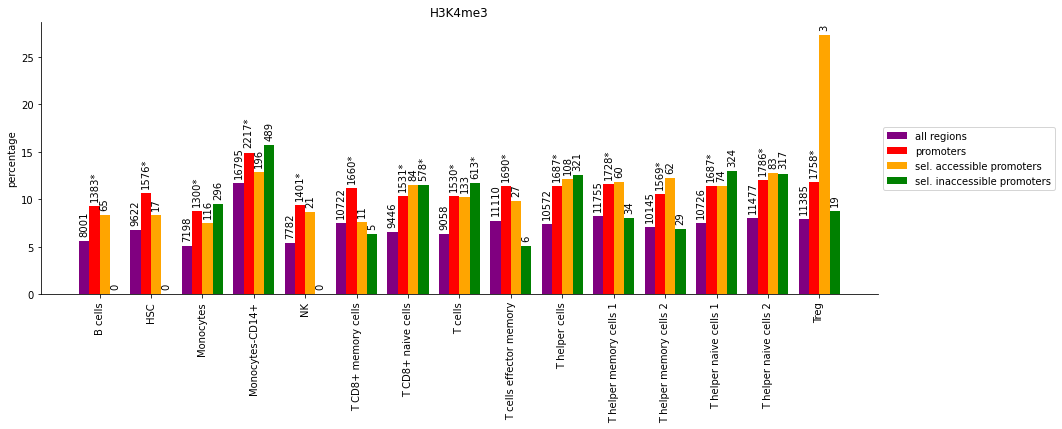

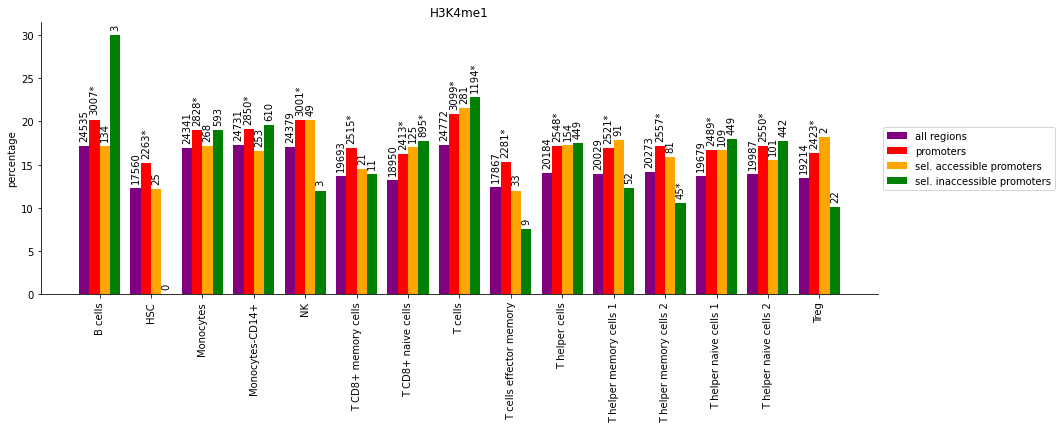

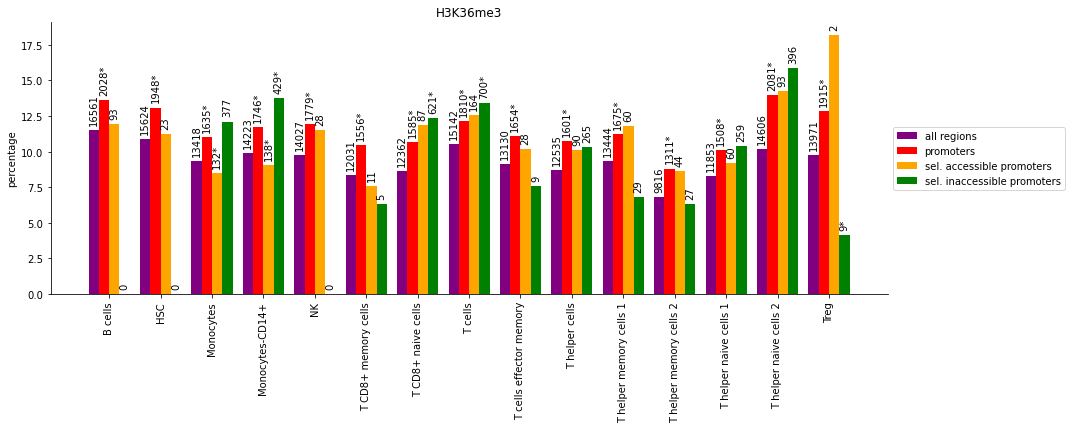

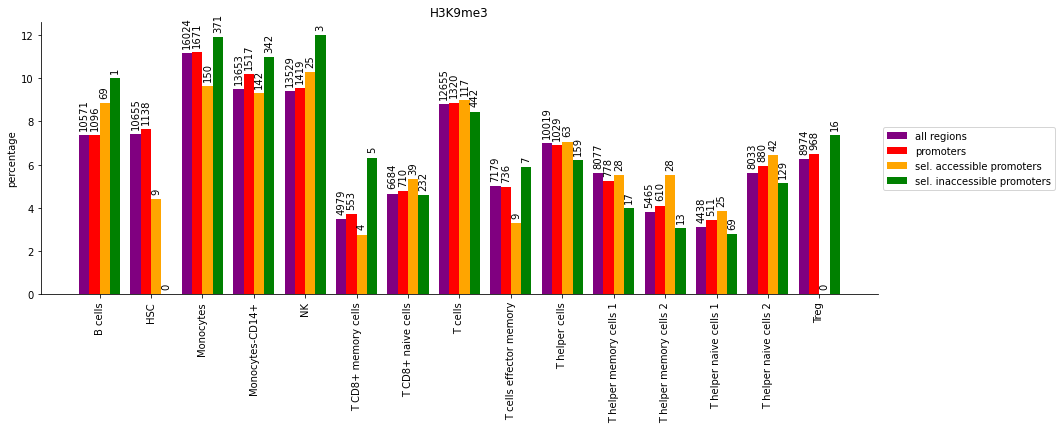

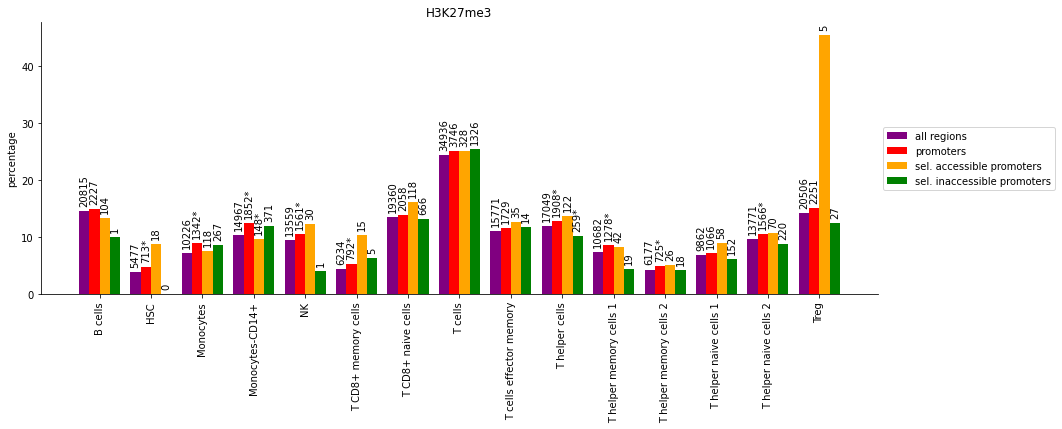

In [19]:
mod_used = ['H3K4me3','H3K4me1','H3K36me3','H3K9me3','H3K27me3']
for mark in mod_used:
    mark_pct(mark)